In [1]:
import cv2
import numpy as np
import seaborn as sns
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
data = os.listdir('dataset/data1/') 

(120, 120)


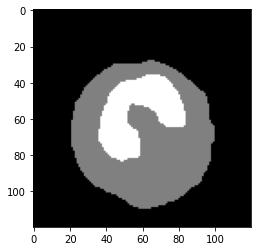

In [40]:
img = cv2.imread('dataset/data1/'+data[-2])
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
print(img.shape)
plt.imshow(img,cmap='gray') #BMP IS IMAGE, PNG IS MASK

In [5]:
image_files = []
mask_files = []
for i in data:
    if '.png' in i:
        mask_files.append(i)
    else:
        image_files.append(i)

In [6]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

X_train,X_test,y_train,y_test = train_test_split(image_files,mask_files,test_size=0.2)

Using TensorFlow backend.


In [153]:
def create(pic,directory_path):
    images = []
    masks = []
    
    p_img = cv2.imread(directory_path+pic)
    name = pic.split('.')[0]
    p_mask = cv2.imread(directory_path+name+'.png')
    p_img = cv2.resize(p_img,(120,120))
    p_mask = cv2.resize(p_mask,(128,128))
    p_img = cv2.resize(p_img,(128,128))
    
    
    p_mask = cv2.cvtColor(p_mask,cv2.COLOR_BGR2GRAY)
   
    
    p_mask[p_mask>0] = 1
    #print(p_mask.max())
    return p_img, p_mask

In [187]:
from keras.utils import to_categorical
import random
def Generator(X_list,batch_size):
    while 1:
        b = 0
        all_i = []
        all_m = []
        random.shuffle(X_list)
        for i in range(batch_size):
            
            image,mask = create(X_list[i-1],'dataset/data1/')
            all_i.append(image)
            mask = mask.reshape((128,128,1))
            all_m.append(mask)
            b+=1
        
        all_i = np.array(all_i)
        all_m = np.array(all_m)
        all_m = to_categorical(all_m)
        #print(all_m[0])
        #print(all_m.shape)
        yield np.array(all_i),np.array(all_m)

In [155]:
#0 IS BACKGROUND, 128 IS CYTOPLASM, 255 IS NUCLEUS
#TO SAVE MEMORY, MADE 0 = BACKGROUND, 1 = CYTOPLASM, 2 = NUCLEUS

In [156]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Dropout,MaxPool2D,BatchNormalization,Activation,Input,Conv2DTranspose,Concatenate,concatenate,UpSampling2D,add,SeparableConv2D,MaxPooling2D

In [186]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=(128,128,3))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(2, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

In [188]:
model = get_model((128,128,3),3)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "functional_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_108 (Conv2D)             (None, 64, 64, 32)   896         input_13[0][0]                   
__________________________________________________________________________________________________
batch_normalization_180 (BatchN (None, 64, 64, 32)   128         conv2d_108[0][0]                 
__________________________________________________________________________________________________
activation_180 (Activation)     (None, 64, 64, 32)   0           batch_normalization_180[0][0]    
______________________________________________________________________________________

In [189]:
print(len(X_train))
print(len(X_train)/5)

240
48.0


In [190]:
gen = Generator(X_train,5)
model.fit(gen,steps_per_epoch=48,epochs=15)

Epoch 1/15
48/48 [==============================] - 1s 21ms/step - loss: 0.4007 - accuracy: 0.9350
Epoch 2/15
48/48 [==============================] - 1s 21ms/step - loss: 0.0817 - accuracy: 0.9668
Epoch 3/15
48/48 [==============================] - 1s 20ms/step - loss: 0.0577 - accuracy: 0.9762
Epoch 4/15
48/48 [==============================] - 1s 21ms/step - loss: 0.0463 - accuracy: 0.9805
Epoch 5/15
48/48 [==============================] - 1s 20ms/step - loss: 0.0439 - accuracy: 0.9814
Epoch 6/15
48/48 [==============================] - 1s 21ms/step - loss: 0.0418 - accuracy: 0.9824
Epoch 7/15
48/48 [==============================] - 1s 20ms/step - loss: 0.0372 - accuracy: 0.9843
Epoch 8/15
48/48 [==============================] - 1s 20ms/step - loss: 0.0342 - accuracy: 0.9855
Epoch 9/15
48/48 [==============================] - 1s 20ms/step - loss: 0.0313 - accuracy: 0.9867
Epoch 10/15
48/48 [==============================] - 1s 20ms/step - loss: 0.0284 - accuracy: 0.9878
Epoch 11/

In [236]:
a,b = create(X_test[8],'dataset/data1/')
pred = model.predict(a.reshape(1,128,128,3))

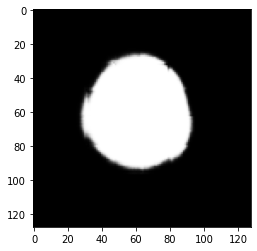

In [237]:
plt.imshow(pred[:,:,:,1].reshape((128,128)),cmap='gray')

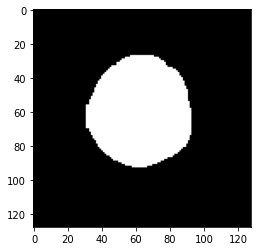

In [230]:
plt.imshow(b,cmap='gray')

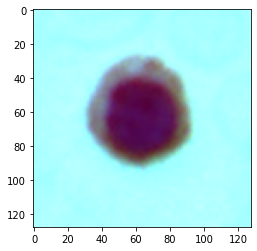

In [231]:
plt.imshow(a)

In [238]:
pred[pred>0.5] = 1
pred[pred<0.6] = 0
pred = pred[:,:,:,1].reshape((128,128))
#print(pred.min())
#plt.imshow(pred[:,:,:,1].reshape((128,128)),cmap='gray')

pred = np.uint8(pred)
a = np.uint8(a)
new_image = cv2.bitwise_and(a, a, mask = pred)

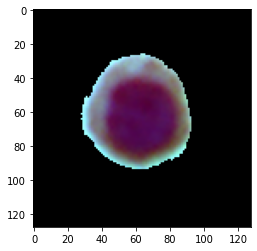

In [239]:
plt.imshow(new_image)

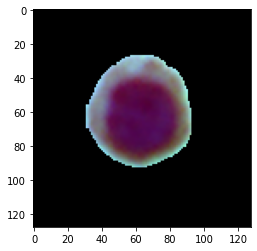

In [234]:
new_image = cv2.bitwise_and(a, a, mask = b)
plt.imshow(new_image)

In [235]:
model.save('wbc_segmentation_model.h5')